In [153]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import pandas as pd
import seaborn as sns

from neutrons.diffusing_neutrons import DiffusingNeutrons
from neutrons.maxwell_boltzmann import MaxwellBoltzmann

In [154]:
def plot_trajectories(positions: np.ndarray, tank = None):

    radius = tank.radius
    height = tank.height
    tank_position = tank.position


    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    
    if tank is not None:
        ax.plot([-radius + tank_position[0], -radius + tank_position[0]], [tank_position[1], tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        ax.plot([tank_position[0], tank_position[0]], [radius + tank_position[1], radius + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")

    for position in positions:
        x = [p[0] for p in position]
        y = [p[1] for p in position]
        z = [p[2] for p in position]
        ax.plot(x, y, z, c="k", linewidth=0.3, alpha=0.5)

    ax.plot(0, 0, 0, "o", c="r")
    ax.set_xlabel("$x(m)$", fontsize=16)
    ax.set_ylabel("$y(m)$", fontsize=16)
    ax.set_box_aspect(aspect=None, zoom=0.9)
    ax.set_zlabel("$z(m)$", fontsize=16)
    ax.set_title("Neutron trajectories")
    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.4, 0.4)
    
    if tank is not None:
        ax.plot([0 + tank_position[0], 0 + tank_position[0]], [-radius + tank_position[1], -radius + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        ax.plot([radius + tank_position[0], radius + tank_position[0]], [0 + tank_position[1], 0 + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, height, 100)
        x = radius * np.outer(np.cos(u), np.ones_like(v)) + tank_position[0]
        y = radius * np.outer(np.sin(u), np.ones_like(v)) + tank_position[1]
        z = np.outer(np.ones_like(u), v) - height/2 + tank_position[2]  # Adjust the height of the cylinder
        ax.plot_surface(x, y, z, color="C0", alpha=0.2)
    plt.show()

In [155]:
H_data =  pd.read_csv("../data/h_cross_t.txt", sep="\s+")
O_data  = pd.read_csv("../data/o_cross_t.txt", sep="\s+")
spectrum_data = pd.read_csv("../data/neutron_spectrum_normalized.txt", sep=",")
cross_data = [H_data, O_data]

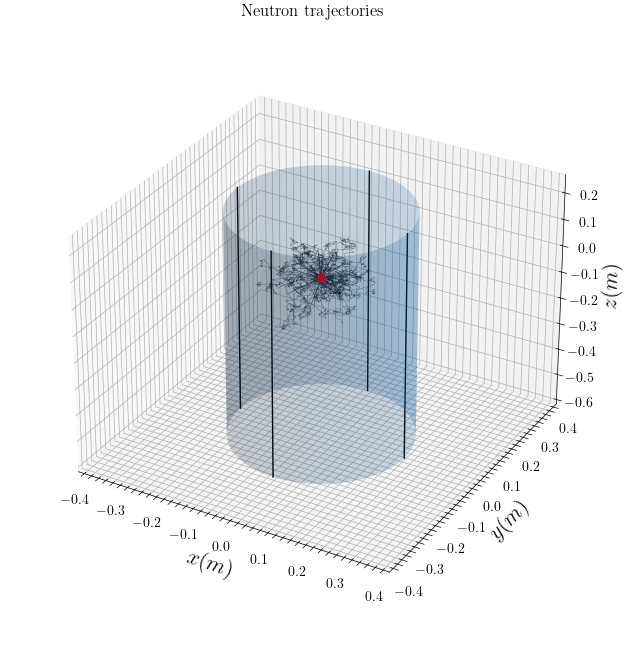

0


In [156]:
nNeutrons = 100
diffusing_neutrons = DiffusingNeutrons(cross_data,spectrum_data, nNeutrons, radius_tank=0.225, height_tank=0.85, position_tank=np.array([0, 0, -0.175]))
diffusing_neutrons.diffuse(nCollisions=30)

plot_trajectories(diffusing_neutrons.get_positions(), diffusing_neutrons.tank)
print(diffusing_neutrons.get_number_escaped())

/tmp/ipykernel_32461/2244472660.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


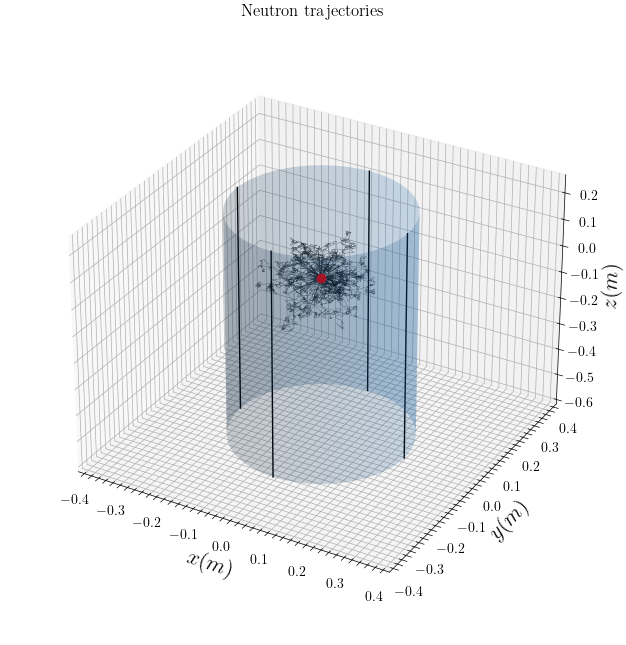

In [157]:
diffusing_neutrons.diffuse(20)
plot_trajectories(diffusing_neutrons.get_positions(), diffusing_neutrons.tank)

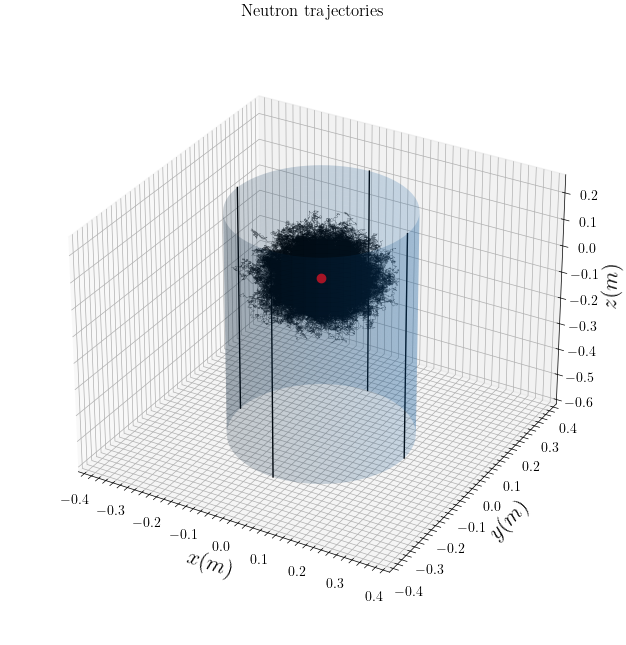

0


In [158]:
nNeutrons = 3000
diffusing_neutrons = DiffusingNeutrons(cross_data,spectrum_data, nNeutrons, radius_tank=0.225, height_tank=0.85, position_tank=np.array([0, 0, -0.175]))
diffusing_neutrons.diffuse(nCollisions=100)

plot_trajectories(diffusing_neutrons.get_positions(), diffusing_neutrons.tank)
print(diffusing_neutrons.get_number_escaped())

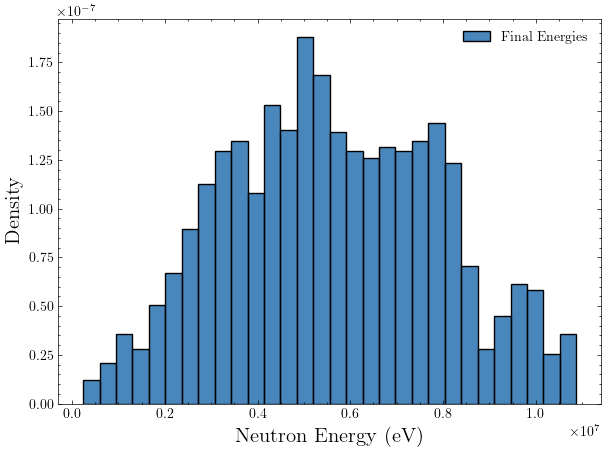

In [159]:
initial_energies = [energies[0] for energies in diffusing_neutrons.get_energies()]
plt.figure(figsize= (7, 5))
sns.histplot(sorted(initial_energies), bins=30,stat="density", label="Final Energies", color="C0")
plt.ylabel("Density", fontsize=15)
plt.xlabel("Neutron Energy (eV)", fontsize=15)
plt.legend()
plt.show()

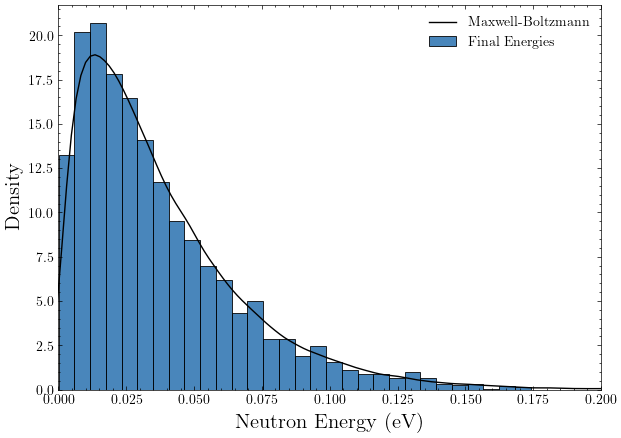

In [160]:
mw = MaxwellBoltzmann()

final_energies = [energies[-1] for energies in diffusing_neutrons.get_energies()]
mw_energies = [mw.thermal_energy() for _ in range(100000)]
plt.figure(figsize= (7, 5))
sns.kdeplot(mw_energies, label="Maxwell-Boltzmann", color="k")
sns.histplot(sorted(final_energies)[:-10], bins=30,stat="density", label="Final Energies", color="C0")
plt.xlim(0, 0.2)
plt.ylabel("Density", fontsize=15)
plt.xlabel("Neutron Energy (eV)", fontsize=15)
plt.legend()
plt.show()